In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
from keras.utils import np_utils
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import ELU, PReLU, LeakyReLU
#from keras.layers.advanced_activations import ELU
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import save_model


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
NB_CLASSES = 4 # number of outputs = number of classes
VERBOSE = 1
BATCH_SIZE = 10
NB_EPOCH = 100
target_names = ['Non-MO', 'MO']
file_short = "D:/BMO/Main/savedModels/10input_model_short.h5"
file_mid1 = "D:/BMO/Main/savedModels/10input_model_mid1.h5"
file_mid2 = "D:/BMO/Main/savedModels/10input_model_mid2.h5"
file_long = "D:/BMO/Main/savedModels/10input_model_long.h5"
file_best = "D:/BMO/Main/savedModels/10input_model_best.h5"

In [3]:
symbol_length =   [1, 128, 1024, 1800, 2048]

In [4]:
%%time

print(".........Loading MO (2-state) dataset..........")


# sep separates each column and header = none means it is going to read from row 1
re2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/BPSK-2/real_snr10.csv',sep=',', header=None) 
im2psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/BPSK-2/im_snr10.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/QPSK-2/real_snr10.csv',sep=',', header=None) 
im4psk_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/QPSK-2/im_snr10.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/16-QAM-2/real_snr10.csv',sep=',', header=None) 
im16qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/16-QAM-2/im_snr10.csv',sep=',', header=None)

# sep separates each column and header = none means it is going to read from row 1
re64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/64-QAM-2/real_snr10.csv',sep=',', header=None) 
im64qam_2st = pd.read_csv('D:/BMO/Main/bigDataset/SNR-based/64-QAM-2/im_snr10.csv',sep=',', header=None)

#merge two dataframes into one
df2psk_2st = re2psk_2st + im2psk_2st * 1j
df2psk_2st['Mod'] = 0 # 0 = BPSK 2-state
#merge two dataframes into one
df4psk_2st = re4psk_2st + im4psk_2st * 1j
df4psk_2st['Mod'] = 1 # 1 = QPSK 2-state
#merge two dataframes into one
df16qam_2st = re16qam_2st + im16qam_2st * 1j
df16qam_2st['Mod'] = 2 # 2 = 16-QAM 2-state
#merge two dataframes into one
df64qam_2st = re64qam_2st + im64qam_2st * 1j
df64qam_2st['Mod'] = 3 # 3 = 64-QAM 2-state

# combine all
df_2st = df2psk_2st.append(df4psk_2st)
df_2st = df_2st.append(df16qam_2st)
df_2st = df_2st.append(df64qam_2st)

#df_mo = df_2st
#df_mo = df_mo.sample(frac = 1)
print('df_mo Shape = ', df_2st.shape)

.........Loading MO (2-state) dataset..........
df_mo Shape =  (28000, 2049)
CPU times: total: 44 s
Wall time: 44.2 s


In [5]:
print("..........Combining all data..........")

# combine all
#df = df_mo.append(df_nonmo)
df_all = df_2st.sample(frac = 1)
print('df_all Shape = ', df_all.shape)
print("..........Shuffling done..........")

# reducing samples to tune only
#df_all = df_all.iloc[:16384]
print('df_all Size = ', df_all.size)
print('Dimension = ', df_all.ndim)
print('Combined Shape = ', df_all.shape)

..........Combining all data..........
df_all Shape =  (28000, 2049)
..........Shuffling done..........
df_all Size =  57372000
Dimension =  2
Combined Shape =  (28000, 2049)


In [6]:
%%time

f1_bp = []
f1_qp = []
f1_16 = []
f1_64 = []
re_bp = []
re_qp = []
re_16 = []
re_64 = []
pr_bp = []
pr_qp = []
pr_16 = []
pr_64 = []
ac_bp = []
ac_qp = []
ac_16 = []
ac_64 = []

f1mc_bp = []
f1mc_qp = []
f1mc_16 = []
f1mc_64 = []
remc_bp = []
remc_qp = []
remc_16 = []
remc_64 = []
prmc_bp = []
prmc_qp = []
prmc_16 = []
prmc_64 = []
acmc_bp = []
acmc_qp = []
acmc_16 = []
acmc_64 = []

accuracy = []
f1score = []
loss = []
precision = []
false_pos = []
true_pos = []
recall = []

for LENGTH in symbol_length:
    
    # Separating X and y
    y = df_all['Mod'] # 1D targer vector
    X = df_all.drop(columns='Mod')

    INPUT_SHAPE = (LENGTH,1)

    X.drop(X.iloc[:, LENGTH:2048], inplace = True, axis = 1)

    X = np.expand_dims(X, -1)

    # Split into training/testing sets with 20% split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1) 

    print("..........Training set..........")
    print(X_train.shape)
    print(y_train.shape)
    print("..........Validation set..........")
    print(X_val.shape)
    print(y_val.shape)
    print("..........Testing set..........")
    print(X_test.shape)
    print(y_test.shape)

    # Convert class vectors to categorical classes matrices
    y_train = np_utils.to_categorical(y_train, NB_CLASSES)
    y_test = np_utils.to_categorical(y_test, NB_CLASSES)
    y_val = np_utils.to_categorical(y_val, NB_CLASSES)

    from keras.constraints import maxnorm

    # Function to create model, required for KerasClassifier
    def create_model():
        # create model
        model = Sequential()
        filter_num = ['None',32,64,128,256]
        kernel_size = ['None',8,8,8,8]
        conv_stride_size = ['None',1,1,1,1]
        pool_stride_size = ['None',4,4,4,4]
        pool_size = ['None',8,8,8,8]
        batch_size = 10
        dropout_rate =0.0
        # Feature extraction
        model.add(Conv1D(filters=filter_num[1], kernel_size=kernel_size[1], input_shape=INPUT_SHAPE,
                             strides=conv_stride_size[1], padding='same',
                             name='convolution1'))
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation1'))
        model.add(MaxPooling1D(pool_size=pool_size[1], strides=pool_stride_size[1],
                                   padding='same', name='pool1'))
        model.add(Dropout(dropout_rate, name='dropout1'))
        
        model.add(BatchNormalization(axis=-1))
        model.add(ELU(alpha=1.0, name='activation2'))
        model.add(MaxPooling1D(pool_size=pool_size[2], strides=pool_stride_size[2],
                                   padding='same', name='pool2'))
        model.add(Dropout(dropout_rate, name='dropout2'))

        # Output layer
        model.add(Flatten(name='flatten1'))
        model.add(Dense(NB_CLASSES, kernel_initializer=glorot_uniform(seed=0), name='dense1'))
        model.add(Activation('softmax', name="softmax"))

        # Compile model
        model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.01, momentum=0.6), metrics=["accuracy"])

        return model

    model = create_model()
    # simple early stopping
    es_lr = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc_lr = ModelCheckpoint(file_best, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    # fit model
    model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
                                validation_data=(X_val, y_val), callbacks=[es_lr, mc_lr])
  #  model_history = model.fit(X_train, y_train, epochs=NB_EPOCH, verbose=VERBOSE, 
   #                             validation_data=(X_val, y_val))
    
    
    if(LENGTH==128):
        save_model(model, file_short)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_short = confusion_matrix(y_test1, y_pred1)
        cmratio_short = cm_short.astype('float') / cm_short.sum(axis=1)[:, np.newaxis]
        cmratio_short= np.around(cmratio_short.astype('float') / cmratio_short.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==512):
        save_model(model, file_mid1)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_mid1 = confusion_matrix(y_test1, y_pred1)
        cmratio_mid1 = cm_mid1.astype('float') / cm_mid1.sum(axis=1)[:, np.newaxis]
        cmratio_mid1= np.around(cmratio_mid1.astype('float') / cmratio_mid1.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==1536):
        save_model(model, file_mid2)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_mid2 = confusion_matrix(y_test1, y_pred1)
        cmratio_mid2 = cm_mid2.astype('float') / cm_mid2.sum(axis=1)[:, np.newaxis]
        cmratio_mid2= np.around(cmratio_mid2.astype('float') / cmratio_mid2.sum(axis=1)[:, np.newaxis], decimals=1)
        
    if(LENGTH==2048):
        save_model(model, file_long)
        print("Saved model to disk")
        print('Confusion Matrix when Symbol Length ', LENGTH)
        cm_long = confusion_matrix(y_test1, y_pred1)
        cmratio_long = cm_long.astype('float') / cm_long.sum(axis=1)[:, np.newaxis]
        cmratio_long= np.around(cmratio_long.astype('float') / cmratio_long.sum(axis=1)[:, np.newaxis], decimals=1)
        
    # Start evaluating model with testing data
    score_test = model.evaluate(X_test, y_test, verbose=VERBOSE)
    y_pred = model.predict(X_test)
    
    y_pred1=np.argmax(y_pred, axis=1)
    y_test1=np.argmax(y_test, axis=1)
    #cm = confusion_matrix(y_test1, y_pred1
    
    acc = score_test[1]
    accuracy.append(acc)
    
    ls = score_test[0]
    loss.append(ls)
    
    f1s = f1_score(y_test1, y_pred1, average=None)
    f1score.append((f1s[0]+f1s[1])/2)
    print(f1s)
    for index, val in np.ndenumerate(f1s):
            if (index[0]==0): 
                f1bp = val
            if (index[0]==1): 
                f1qp = val
            if (index[0]==2):
                f116 = val
            if (index[0]==3): 
                f164 = val
           
    f1_bp.append(f1bp)
    f1_qp.append(f1qp)
    f1_16.append(f116)
    f1_64.append(f164)
    
    
    cm = confusion_matrix(y_test1, y_pred1)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print('Confusion Matrix when Symbol Length ', LENGTH)
    #f = sns.heatmap(cm, cmap='Greens', annot=True, square=True, yticklabels = True)
    #cmratio = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #plt.rcParams["figure.figsize"] = (7.5,7.5)
    #plt.rcParams.update({'font.size': 14})
    #f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)
    
    accuracys = cm.diagonal()
    #acc = accuracy.reshape(-1,1)
    print(accuracys)
    for index, val in np.ndenumerate(accuracys):
            if (index[0]==0): 
                abp = val
            if (index[0]==1): 
                aqp = val
            if (index[0]==2):
                a16 = val
            if (index[0]==3): 
                a64 = val
           
    ac_bp.append(abp)
    ac_qp.append(aqp)
    ac_16.append(a16)
    ac_64.append(a64)

..........Training set..........
(20160, 1, 1)
(20160,)
..........Validation set..........
(2240, 1, 1)
(2240,)
..........Testing set..........
(5600, 1, 1)
(5600,)
Epoch 1/100
603/630 [===========================>..] - ETA: 0s - loss: 1.4012 - accuracy: 0.2508
Epoch 1: val_accuracy improved from -inf to 0.25536, saving model to D:/BMO/Main/savedModels\10input_model_best.h5
630/630 [==============================] - 2s 2ms/step - loss: 1.4007 - accuracy: 0.2509 - val_loss: 1.3925 - val_accuracy: 0.2554
Epoch 2/100
596/630 [===========================>..] - ETA: 0s - loss: 1.3900 - accuracy: 0.2546
Epoch 2: val_accuracy did not improve from 0.25536
630/630 [==============================] - 1s 1ms/step - loss: 1.3903 - accuracy: 0.2532 - val_loss: 1.3903 - val_accuracy: 0.2451
Epoch 3/100
616/630 [============================>.] - ETA: 0s - loss: 1.3894 - accuracy: 0.2538
Epoch 3: val_accuracy did not improve from 0.25536
630/630 [==============================] - 1s 1ms/step - loss: 1.

630/630 [==============================] - 1s 1ms/step - loss: 1.3898 - accuracy: 0.2465 - val_loss: 1.3870 - val_accuracy: 0.2679
Epoch 29/100
625/630 [============================>.] - ETA: 0s - loss: 1.3892 - accuracy: 0.2505
Epoch 29: val_accuracy did not improve from 0.26786
630/630 [==============================] - 1s 1ms/step - loss: 1.3892 - accuracy: 0.2500 - val_loss: 1.3891 - val_accuracy: 0.2594
Epoch 30/100
625/630 [============================>.] - ETA: 0s - loss: 1.3889 - accuracy: 0.2544
Epoch 30: val_accuracy did not improve from 0.26786
630/630 [==============================] - 1s 1ms/step - loss: 1.3889 - accuracy: 0.2545 - val_loss: 1.3903 - val_accuracy: 0.2464
Epoch 31/100
616/630 [============================>.] - ETA: 0s - loss: 1.3901 - accuracy: 0.2448
Epoch 31: val_accuracy did not improve from 0.26786
630/630 [==============================] - 1s 1ms/step - loss: 1.3900 - accuracy: 0.2461 - val_loss: 1.3945 - val_accuracy: 0.2433
Epoch 31: early stopping
1

Epoch 23/100
630/630 [==============================] - ETA: 0s - loss: 0.4555 - accuracy: 0.7989
Epoch 23: val_accuracy did not improve from 0.80937
630/630 [==============================] - 3s 4ms/step - loss: 0.4555 - accuracy: 0.7989 - val_loss: 0.4901 - val_accuracy: 0.7866
Epoch 24/100
628/630 [============================>.] - ETA: 0s - loss: 0.4471 - accuracy: 0.8019
Epoch 24: val_accuracy did not improve from 0.80937
630/630 [==============================] - 3s 4ms/step - loss: 0.4472 - accuracy: 0.8017 - val_loss: 0.4493 - val_accuracy: 0.7973
Epoch 25/100
630/630 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.7980
Epoch 25: val_accuracy did not improve from 0.80937
630/630 [==============================] - 3s 4ms/step - loss: 0.4516 - accuracy: 0.7980 - val_loss: 0.4514 - val_accuracy: 0.8018
Epoch 26/100
621/630 [============================>.] - ETA: 0s - loss: 0.4490 - accuracy: 0.8002
Epoch 26: val_accuracy did not improve from 0.80937
630/630

630/630 [==============================] - 3s 4ms/step - loss: 0.4275 - accuracy: 0.8082 - val_loss: 0.4438 - val_accuracy: 0.8076
Epoch 52/100
624/630 [============================>.] - ETA: 0s - loss: 0.4317 - accuracy: 0.8079
Epoch 52: val_accuracy did not improve from 0.81696
630/630 [==============================] - 3s 4ms/step - loss: 0.4311 - accuracy: 0.8083 - val_loss: 0.4479 - val_accuracy: 0.8022
Epoch 53/100
620/630 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.8082
Epoch 53: val_accuracy did not improve from 0.81696
630/630 [==============================] - 3s 5ms/step - loss: 0.4295 - accuracy: 0.8081 - val_loss: 0.4420 - val_accuracy: 0.8076
Epoch 54/100
626/630 [============================>.] - ETA: 0s - loss: 0.4262 - accuracy: 0.8106
Epoch 54: val_accuracy did not improve from 0.81696
630/630 [==============================] - 3s 4ms/step - loss: 0.4264 - accuracy: 0.8106 - val_loss: 0.4524 - val_accuracy: 0.8058
Epoch 55/100
630/630 [====

Epoch 81/100
627/630 [============================>.] - ETA: 0s - loss: 0.4184 - accuracy: 0.8126
Epoch 81: val_accuracy did not improve from 0.81696
630/630 [==============================] - 3s 4ms/step - loss: 0.4182 - accuracy: 0.8127 - val_loss: 0.4407 - val_accuracy: 0.8098
Epoch 82/100
625/630 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8124
Epoch 82: val_accuracy did not improve from 0.81696
630/630 [==============================] - 3s 4ms/step - loss: 0.4195 - accuracy: 0.8127 - val_loss: 0.4351 - val_accuracy: 0.8094
Epoch 83/100
624/630 [============================>.] - ETA: 0s - loss: 0.4167 - accuracy: 0.8119
Epoch 83: val_accuracy did not improve from 0.81696
630/630 [==============================] - 3s 4ms/step - loss: 0.4168 - accuracy: 0.8120 - val_loss: 0.4305 - val_accuracy: 0.8161
Epoch 84/100
619/630 [============================>.] - ETA: 0s - loss: 0.4173 - accuracy: 0.8138
Epoch 84: val_accuracy did not improve from 0.81696
630/630

629/630 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.9791
Epoch 7: val_accuracy did not improve from 0.97321
630/630 [==============================] - 15s 24ms/step - loss: 0.0610 - accuracy: 0.9791 - val_loss: 0.2925 - val_accuracy: 0.9022
Epoch 8/100
630/630 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9768
Epoch 8: val_accuracy did not improve from 0.97321
630/630 [==============================] - 15s 23ms/step - loss: 0.0654 - accuracy: 0.9768 - val_loss: 0.0863 - val_accuracy: 0.9723
Epoch 9/100
628/630 [============================>.] - ETA: 0s - loss: 0.0528 - accuracy: 0.9821
Epoch 9: val_accuracy did not improve from 0.97321
630/630 [==============================] - 15s 23ms/step - loss: 0.0527 - accuracy: 0.9821 - val_loss: 0.1027 - val_accuracy: 0.9629
Epoch 10/100
629/630 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9853
Epoch 10: val_accuracy improved from 0.97321 to 0.97455, saving model t

Epoch 35: early stopping
175/175 [==============================] - 1s 6ms/step
[0.95296671 0.95667365 0.99927273 0.99362606]
[0.94206009 0.9613764  0.99927273 1.        ]
..........Training set..........
(20160, 1800, 1)
(20160,)
..........Validation set..........
(2240, 1800, 1)
(2240,)
..........Testing set..........
(5600, 1800, 1)
(5600,)
Epoch 1/100
630/630 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.8521
Epoch 1: val_accuracy improved from -inf to 0.93125, saving model to D:/BMO/Main/savedModels\10input_model_best.h5
630/630 [==============================] - 25s 38ms/step - loss: 0.7334 - accuracy: 0.8521 - val_loss: 0.1769 - val_accuracy: 0.9312
Epoch 2/100
630/630 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9711
Epoch 2: val_accuracy improved from 0.93125 to 0.97321, saving model to D:/BMO/Main/savedModels\10input_model_best.h5
630/630 [==============================] - 25s 39ms/step - loss: 0.0914 - accuracy: 0.9711 - v

630/630 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 26: val_accuracy did not improve from 0.99464
630/630 [==============================] - 25s 40ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 0.9924
Epoch 27/100
630/630 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000
Epoch 27: val_accuracy did not improve from 0.99464
630/630 [==============================] - 25s 40ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9946
Epoch 28/100
630/630 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9999
Epoch 28: val_accuracy did not improve from 0.99464
630/630 [==============================] - 26s 41ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0200 - val_accuracy: 0.9929
Epoch 29/100
629/630 [============================>.] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000
Epoch 29: val_accuracy did not improve from 0.99464
630/630 [=====

630/630 [==============================] - 26s 41ms/step - loss: 6.1831e-04 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 0.9937
Epoch 55/100
630/630 [==============================] - ETA: 0s - loss: 6.1547e-04 - accuracy: 1.0000
Epoch 55: val_accuracy did not improve from 0.99509
630/630 [==============================] - 25s 40ms/step - loss: 6.1547e-04 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 0.9946
Epoch 56/100
630/630 [==============================] - ETA: 0s - loss: 6.2358e-04 - accuracy: 1.0000
Epoch 56: val_accuracy did not improve from 0.99509
630/630 [==============================] - 25s 40ms/step - loss: 6.2358e-04 - accuracy: 1.0000 - val_loss: 0.0190 - val_accuracy: 0.9951
Epoch 57/100
630/630 [==============================] - ETA: 0s - loss: 5.8864e-04 - accuracy: 1.0000
Epoch 57: val_accuracy did not improve from 0.99509
630/630 [==============================] - 25s 40ms/step - loss: 5.8864e-04 - accuracy: 1.0000 - val_loss: 0.0192 - val_accurac

629/630 [============================>.] - ETA: 0s - loss: 0.0066 - accuracy: 0.9991
Epoch 15: val_accuracy did not improve from 0.98259
630/630 [==============================] - 29s 45ms/step - loss: 0.0066 - accuracy: 0.9991 - val_loss: 0.0747 - val_accuracy: 0.9728
Epoch 16/100
629/630 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.9990
Epoch 16: val_accuracy did not improve from 0.98259
630/630 [==============================] - 29s 46ms/step - loss: 0.0068 - accuracy: 0.9990 - val_loss: 0.0487 - val_accuracy: 0.9821
Epoch 17/100
630/630 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9975
Epoch 17: val_accuracy did not improve from 0.98259
630/630 [==============================] - 29s 46ms/step - loss: 0.0095 - accuracy: 0.9975 - val_loss: 0.0452 - val_accuracy: 0.9826
Epoch 18/100
629/630 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.9934
Epoch 18: val_accuracy did not improve from 0.98259
630/630 [=====

630/630 [==============================] - 30s 48ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0436 - val_accuracy: 0.9853
Epoch 44/100
629/630 [============================>.] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 44: val_accuracy did not improve from 0.98616
630/630 [==============================] - 30s 48ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0463 - val_accuracy: 0.9839
Epoch 45/100
630/630 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000
Epoch 45: val_accuracy did not improve from 0.98616
630/630 [==============================] - 30s 48ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 0.9853
Epoch 46/100
629/630 [============================>.] - ETA: 0s - loss: 9.1834e-04 - accuracy: 1.0000
Epoch 46: val_accuracy did not improve from 0.98616
630/630 [==============================] - 30s 48ms/step - loss: 9.1761e-04 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9812
Epoch 47/1

In [7]:
print("Symbol series length = ", LENGTH)

y_pred1=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test1, y_pred1)
print(cm)
#f = sns.heatmap(cm, cmap='Purples', annot=True, square=True, yticklabels = True)

Symbol series length =  2048
[[1372   25    0    1]
 [  25 1399    0    0]
 [   0    0 1375    0]
 [   0    0    0 1403]]


In [8]:
print(accuracy)

[0.24142856895923615, 0.7850000262260437, 0.9755356907844543, 0.9941071271896362, 0.9908928275108337]


[0.24142856895923615, 0.7850000262260437, 0.9755356907844543, 0.9941071271896362, 0.9908928275108337]
[1.397979736328125, 0.4605739116668701, 0.07377341389656067, 0.015732940286397934, 0.024619247764348984]
[0.0, 0.6217028011157694, 0.954820184846398, 0.9884763862598631, 0.9820984754075295]


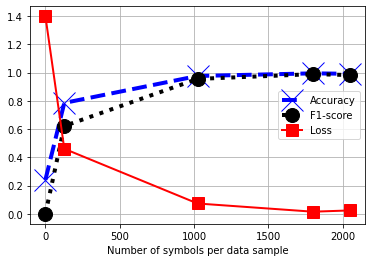

In [9]:
print(accuracy)
print(loss)
print(f1score)
# Plot Graph
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 30})

fig, ax1 = plt.subplots()

ax1.plot(symbol_length, accuracy, color='b', linestyle='dashed', linewidth =4,
         marker='x', markerfacecolor='white', markersize=22, label='Accuracy')
ax1.plot(symbol_length, f1score, color='k', linestyle=':', linewidth =4,
         marker='o', markerfacecolor='k', markersize=14, label='F1-score')
ax1.plot(symbol_length, loss, color='r', linestyle='-', linewidth = 2,
         marker='s', markerfacecolor='r', markersize=12, label='Loss')

ax1.set_xlabel('Number of symbols per data sample')
#ax1.set_ylabel('Score')
plt.grid()
#plt.ylim(0.14, 1.0)
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='center right')

plt.show()